In [8]:
import numpy as np 
import pandas as pd
from sklearn import *
import numpy as np
import matplotlib.pyplot as plt

In [12]:
train = pd.read_csv('E:/Local Disk/datasets/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('E:/Local Disk/datasets/competitive-data-science-predict-future-sales/test.csv')
submission =  pd.read_csv('E:/Local Disk/datasets/competitive-data-science-predict-future-sales/sample_submission.csv')
item = pd.read_csv('E:/Local Disk/datasets/competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv('E:/Local Disk/datasets/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('E:/Local Disk/datasets/competitive-data-science-predict-future-sales/shops.csv')

In [13]:
#prepare date and time

train['date']= pd.to_datetime(train['date'], format='%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year']=train['date'].dt.year
train = train.drop(['date','item_price'],axis=1)
train = train.groupby([c for c in train.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})

shop_item_mean = train[['shop_id','item_id','item_cnt_month']].groupby(['shop_id','item_id'],as_index=False)[['item_cnt_month']].mean()

shop_item_mean =  shop_item_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})



In [14]:
# Add mean feature to our train set
train =pd.merge(train, shop_item_mean, how='left', on=['shop_id','item_id'])

In [15]:
train.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean
0,0,0,32,1,2013,6,8.0
1,0,0,33,1,2013,3,3.0
2,0,0,35,1,2013,1,7.5
3,0,0,43,1,2013,1,1.0
4,0,0,51,1,2013,2,2.5


In [16]:
# Add last month

shop_prev_month = train[train['date_block_num']==10][['shop_id','item_id','item_cnt_month']]

shop_prev_month = shop_prev_month.rename(columns = {'item_cnt_month':'item_cnt_prev_month'})

#ADD previous month featutre to train dataset

train = pd.merge(train, shop_prev_month, how='left', on=['shop_id','item_id']).fillna(0.)

#Add item and feature 

train = pd.merge(train, item, how='left', on='item_id')

#Adding item category feature
train = pd.merge(train, item_cats, how='left', on='item_category_id')


#Adding shop feature
train = pd.merge(train, shops, how='left',on='shop_id')
train.head()


,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
0,0,0,32,1,2013,6,8.0,0.0,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,1,2013,3,3.0,0.0,1+1 (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,1,2013,1,7.5,0.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,1,2013,1,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,1,2013,2,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"


In [17]:
# Adding November 2016
test['month']= 11
test['year']=2015
test['date_block_num']=34

# Add meanfeature
test = pd.merge(test, shop_item_mean, how='left', on=['shop_id', 'item_id']).fillna(0.)

# Add previous month feature
test = pd.merge(test, shop_prev_month, how='left', on=['shop_id','item_id']).fillna(0.)

#Add item and feature 

test = pd.merge(test, item, how='left', on='item_id')

#Adding item category feature
test = pd.merge(test, item_cats, how='left', on='item_category_id')

#Adding shop feature
test = pd.merge(test, shops, how='left',on='shop_id')

test['item_cnt_month']=0.



In [18]:
#label encoding 

for c in ['shop_name','item_name','item_category_name']:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[c].unique())+list(test[c].unique()))
    train[c] = lbl.transform(train[c].astype(str))
    test[c] = lbl.transform(test[c].astype(str))
    print(c)

shop_name
item_name
item_category_name


In [19]:
# let train and predict using random forest algorithm

col = [c for c in train.columns if c not in ['item_cnt_month']]
x1 =  train[train['date_block_num']<33]
y1 = np.log1p(x1['item_cnt_month'].clip(0. ,20. ))
x1 = x1[col]
x2 = train[train['date_block_num']<33]
y2 = np.log1p(x2['item_cnt_month'].clip(0. ,20.))
x2 = x2[col]

reg = ensemble.ExtraTreesRegressor(n_estimators = 30, n_jobs= -1, max_depth=20, random_state = 18)
reg.fit(x1, y1)
print('RSME value is : ',np.sqrt(metrics.mean_squared_error(y2.clip(0.,20.),reg.predict(x2).clip(0.,20.))))

RSME value is :  0.20586002563831582


In [20]:
#train 

reg.fit(train[col],train['item_cnt_month'].clip(0.,20.))
test['item_cnt_month'] = reg.predict(test[col]).clip(0. ,20.)
test[['ID','item_cnt_month']].to_csv('submission.csv',index=False)

test['item_cnt_month']= np.expm1(test['item_cnt_month'])
test[['ID','item_cnt_month']].to_csv('final_submission.csv',index=False)


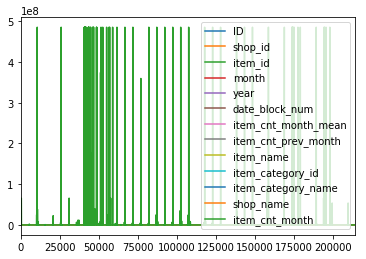

In [21]:
test.plot()